In [1]:
import os
import sys
import multiprocessing
import gensim 
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation, DBSCAN, AgglomerativeClustering, MiniBatchKMeans
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)

In [2]:
#https://github.com/3Top/word2vec-api#where-to-get-a-pretrained-models
#http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/

path_io_files = '../../datasets/Word2Vec/'

### Google News Model

In [3]:
googlenews = os.path.join(path_io_files,'GoogleNews-vectors-negative300.bin.gz')
questions = os.path.join(path_io_files,'questions-words.txt')

In [4]:
model_googlenews = gensim.models.KeyedVectors.load_word2vec_format(googlenews, binary=True)

In [5]:
evals = open(questions, 'r').readlines()
num_sections = len([l for l in evals if l.startswith(':')])
print('total evaluation sentences: {} '.format(len(evals) - num_sections))

total evaluation sentences: 19544 


In [6]:
def w2v_model_accuracy(model):
    accuracy = model.accuracy(questions)
    sum_corr = len(accuracy[-1]['correct'])
    sum_incorr = len(accuracy[-1]['incorrect'])
    total = sum_corr + sum_incorr
    percent = lambda a: a / total * 100
    print('Total sentences: {}, Correct: {:.2f}%, Incorrect: {:.2f}%'.format(total, 
                                                                             percent(sum_corr), 
                                                                             percent(sum_incorr)))

In [7]:
w2v_model_accuracy(model_googlenews)

Total sentences: 13190, Correct: 77.08%, Incorrect: 22.92%


In [8]:
model_googlenews.most_similar("queen")

[('queens', 0.7399442195892334),
 ('princess', 0.7070531845092773),
 ('king', 0.6510956883430481),
 ('monarch', 0.6383601427078247),
 ('very_pampered_McElhatton', 0.6357026696205139),
 ('Queen', 0.6163408756256104),
 ('NYC_anglophiles_aflutter', 0.6060680150985718),
 ('Queen_Consort', 0.592379629611969),
 ('princesses', 0.5908075571060181),
 ('royal', 0.5637185573577881)]

In [9]:
print(model_googlenews.doesnt_match("captain onion starship alien".split()))
print(model_googlenews.doesnt_match("father mother son daughter film".split()))
print(model_googlenews.doesnt_match("france england germany berlin".split()))
print(model_googlenews.most_similar("man"))
print(model_googlenews.most_similar("queen"))
print(model_googlenews.most_similar("awful"))

onion
film
berlin
[('woman', 0.7664012312889099), ('boy', 0.6824870109558105), ('teenager', 0.6586930155754089), ('teenage_girl', 0.6147903800010681), ('girl', 0.5921714305877686), ('suspected_purse_snatcher', 0.571636438369751), ('robber', 0.5585119724273682), ('Robbery_suspect', 0.5584409236907959), ('teen_ager', 0.5549196600914001), ('men', 0.5489763021469116)]
[('queens', 0.7399442195892334), ('princess', 0.7070531845092773), ('king', 0.6510956883430481), ('monarch', 0.6383601427078247), ('very_pampered_McElhatton', 0.6357026696205139), ('Queen', 0.6163408756256104), ('NYC_anglophiles_aflutter', 0.6060680150985718), ('Queen_Consort', 0.592379629611969), ('princesses', 0.5908075571060181), ('royal', 0.5637185573577881)]
[('horrible', 0.7597668170928955), ('terrible', 0.7478911876678467), ('dreadful', 0.7218177318572998), ('horrendous', 0.6970030069351196), ('horrid', 0.6720176935195923), ('atrocious', 0.6626646518707275), ('ugly', 0.6236302852630615), ('lousy', 0.6135216951370239), 

### Media Cloud Model

In [10]:
#mediacloud = os.path.join(path_io_files, 'MediaCloud_w2v')
mediacloud = os.path.join(path_io_files, 'MediaCloud_w2v_trigrams')

In [11]:
model_mediacloud = gensim.models.Word2Vec.load(mediacloud)

In [12]:
model_mediacloud.most_similar('fgv')

[('fundação_getúlio', 0.7404108047485352),
 ('vargas_fgv', 0.7010539770126343),
 ('fundação_getulio', 0.7001169323921204),
 ('ibre', 0.6558458209037781),
 ('eesp', 0.6423794031143188),
 ('getulio_vargas', 0.6356330513954163),
 ('eaesp', 0.628360390663147),
 ('economia_ibre', 0.625259518623352),
 ('economia_fundação', 0.6108883619308472),
 ('ibre_fgv', 0.6033610701560974)]

In [13]:
def build_neighbors(word, model, nviz=15):
    g = nx.Graph()
    g.add_node(word, {'color':'blue'})
    viz1 = model.most_similar(word, topn=nviz)
    g.add_weighted_edges_from([(word, v, w) for v,w in viz1 if w> 0.5] )
    for v in viz1:
        g.add_weighted_edges_from([(v[0], v2, w2) for v2,w2 in model.most_similar(v[0])])
    return g

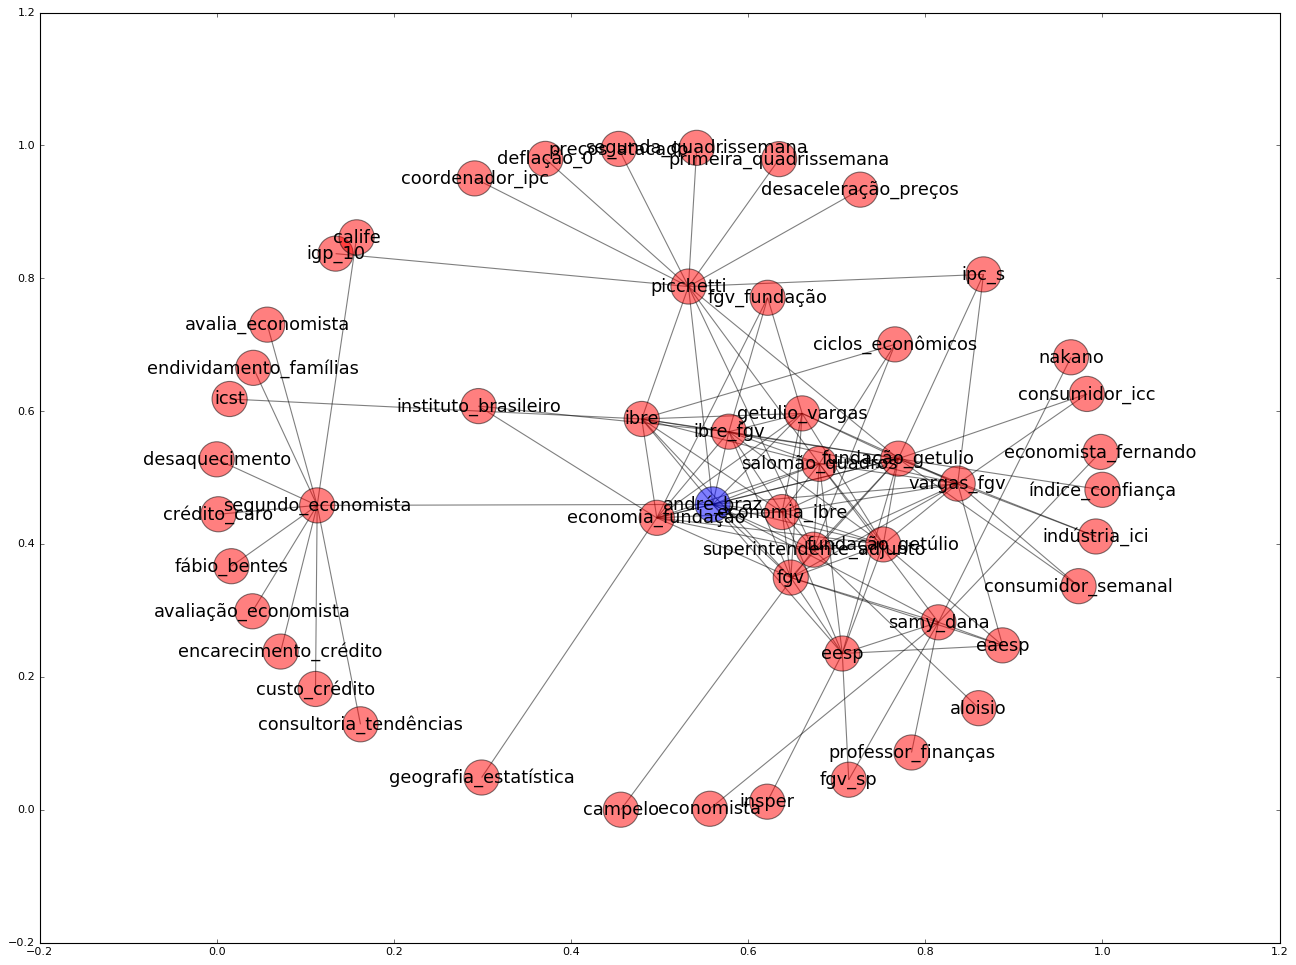

In [14]:
word = 'andré_braz'
g = build_neighbors(word, model_mediacloud)
cols = ['r']*len(g.nodes()); cols[g.nodes().index(word)]='b'
pos = nx.spring_layout(g, iterations=100)
nx.draw_networkx(g,pos=pos, node_color=cols, node_size=1000, alpha=0.5, font_size=16)
#nx.draw_networkx_labels(g, pos,dict(zip(g.nodes(),g.nodes())))

### Wikipedia Model

(You'll need at least 36GB RAM to process this file)  

In [21]:
# Download the raw xml file from wikimedia
# https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2
wikipedia = os.path.join(path_io_files,'enwiki-latest-pages-articles.xml.bz2')

# Use this tool to open the wikimedia dump
wiki = WikiCorpus(wikipedia, lemmatize=False, dictionary={})

In [25]:
# Create a new file and save the processed dump
with open(os.path.join(path_io_files,'wikimedia_processed_w2v'), 'w') as f:
    for text in wiki.get_texts():
        f.write(' '.join(map(str,text)) + "\n")

In [15]:
#Create a model based in the processed dump 
with open(os.path.join(path_io_files,'wikimedia_processed_w2v'), 'r') as f:
    model_wikipedia = Word2Vec(LineSentence(f), size=400, window=5, min_count=5, workers=multiprocessing.cpu_count())

In [16]:
# Trim unneeded model memory = use (much) less RAM
model_wikipedia.init_sims(replace=True)
# Save as a model
model_wikipedia.save(os.path.join(path_io_files,'model_wikimedia_w2v'))

In [ ]:
# Now you can load only the trimmed model and forget the other files
model_wikipedia = gensim.models.Word2Vec.load_word2vec_format('model_wikimedia_w2v', binary=False)

In [31]:
model_wikipedia.wv.vocab["b'tee'"].count

9727

In [29]:
print(model_wikipedia.most_similar("b'queen'"))
print(model_wikipedia.most_similar("b'man'"))
print(model_wikipedia.most_similar("b'woman'"))
print(model_wikipedia.similarity("b'woman'", "b'man'"))
print(model_wikipedia.doesnt_match("b'breakfast' b'cereal' b'dinner' b'lunch'".split()))
print(model_wikipedia.similarity("b'woman'", "b'girl'"))
print(model_wikipedia.most_similar("b'frog'"))

[("b'princess'", 0.6584410667419434), ("b'king'", 0.634395956993103), ("b'empress'", 0.5904576778411865), ("b'pxqueen'", 0.5289260149002075), ("b'monarch'", 0.5246022939682007), ("b'spudvilas'", 0.5126129388809204), ("b'\\xca\\xbbahome\\xca\\xbbe'", 0.5018028616905212), ("b'paisieva'", 0.5015050768852234), ("b'mata\\xca\\xbbaho'", 0.500234842300415), ("b'pedersdotter'", 0.49353304505348206)]
[("b'woman'", 0.6949270963668823), ("b'boy'", 0.613233208656311), ("b'girl'", 0.6063334345817566), ("b'person'", 0.5223042964935303), ("b'stranger'", 0.5063459277153015), ("b'drunkard'", 0.48354315757751465), ("b'thug'", 0.48234057426452637), ("b'warrior'", 0.4783574044704437), ("b'thief'", 0.47541743516921997), ("b'policeman'", 0.46974894404411316)]
[("b'girl'", 0.70760577917099), ("b'man'", 0.6949270963668823), ("b'prostitute'", 0.611080527305603), ("b'person'", 0.6061965823173523), ("b'seductress'", 0.5591270923614502), ("b'divorcee'", 0.5489296317100525), ("b'schoolgirl'", 0.5429136753082275), 

In [ ]:
w2v_model_accuracy(model_wikipedia)